# Задания

In [52]:
import numpy as np
import pandas as pd

## Задание 1

Загрузи данные о посещениях заведений. В них содержится информация о регистрации пользователя в заведениях 
и геолокация этих заведений. Очисти данные от записей с пропусками. \
Выведи количество записей после очистки. 

In [2]:
data = pd.read_csv('../datasets/checkins.dat', sep='|', skipinitialspace=True, low_memory=False) 
df = data.drop(0)
df = df.rename(columns=lambda x: x.strip())
df = df.replace(' ', '') 
df = df.dropna()
df.shape

(396634, 6)

## Задание 2

Эти данные содержат информацию о заведениях со всего мира. С помощью геолокаций и библиотеки [Reverse Geocoder](https://github.com/thampiman/reverse-geocoder),
узнай страну для каждой геопозиции. \
Узнай **название** второй страны по количеству записей.

In [71]:
import reverse_geocoder as rg
import pycountry
df_la_lo = list(zip(df['latitude'], df['longitude']))
results = rg.search(df_la_lo)
df['country'] = [country['cc'] for country in results]
print('Индонезия : =' ,pycountry.countries.get(alpha_2 = df['country'].value_counts().index[1]).name)


Индонезия : = Indonesia


## Задание 3

Нас будут интересовать только американские локации. Очисти данные от локаций, находящихся в других странах. 
Также, чтобы сократить количество, геолокаций оставь в выборке только 50 самых часто встречаемых заведений (venue). \
Выведи количество локаций, оставшихся после этих очисток.

In [4]:
df_us = df[(df['country'].str.contains('US'))]
df_us_top = df_us['venue_id'].value_counts().head(50)
df_us_top = list(df_us_top.index)
df_us_50 = df_us.loc[df_us['venue_id'].isin(df_us_top)] 
df_us_50.shape

(162099, 7)

## Задание 4

Перейдем к задаче кластеризации. Воспользуйся алгоритмом [Mean Shift](https://scikit-learn.org/stable/modules/clustering.html#mean-shift)
для кластеризации локаций. Параметрами укажи `MeanShift(bandwidth=0.1, bin_seeding=True)`. 

    `bandwidth=0.1` - это ширина ядра кластеризации. Для средних широт США - это порядка 5-10 км. 
    `bin_seeding=True` - для ускорения работы алгоритма.
    
Выведи количество кластеров, которые у тебя получились в результате кластеризации.

In [5]:
from sklearn.cluster import MeanShift
import numpy as np
df_lalo_us_50 = list(zip(df_us_50['latitude'], df_us_50['longitude']))
X = np.array(df_lalo_us_50)

ms = MeanShift(bandwidth=0.1, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)
n_clusters_

2846

## Задание 5

Центры полученных кластеров - это потенциальные места установки банеров компании. Теперь хотелось бы найти те центры кластеров, 
которые наиболее близко находятся к офисам продаж компании. \
Загрузи [данные по координатам офисов компании](datasets/offices.csv). Для каждого офиса найди 5 самых ближайших к нему центров кластеров. 
(Пренебрежем тем, что Земля круглая и рассчитаем Евклидово расстояние).
У компании 11 офисов, значит у нас должно получится 55 мест установки баннеров. \
Выведи координаты установки баннера, который ближе всего находится к офису компании.

In [60]:
import scipy.spatial as spatial
import scipy.spatial as spatial
from scipy.spatial import KDTree

df_offices = pd.read_csv('../datasets/offices.csv', index_col=0)
R = 6367

df_centers = pd.DataFrame(ms.cluster_centers_.tolist(), columns=['latitude', 'longitude'])
phi = np.deg2rad(df_centers['latitude'])
theta = np.deg2rad(df_centers['longitude'])
df_centers['x'] = R * np.cos(phi) * np.cos(theta)
df_centers['y'] = R * np.cos(phi) * np.sin(theta)
df_centers['z'] = R * np.sin(phi)

phi1 = np.deg2rad(df_offices['latitude'])
theta1 = np.deg2rad(df_offices['longitude'])
df_offices['x'] = R * np.cos(phi1) * np.cos(theta1)
df_offices['y'] = R * np.cos(phi1) * np.sin(theta1)
df_offices['z'] = R * np.sin(phi1)
tree = spatial.KDTree(df_centers[['x', 'y', 'z']])

dd, ii, = tree.query(df_offices[['x', 'y', 'z']], k=5)
nearest = np.unravel_index(dd.argmin(),dd.shape)[0]+1
latn, lonn = df_centers [['latitude', 'longitude']].loc[ii[np.unravel_index(dd.argmin(),dd.shape)]]
latn, lonn

(32.78531777579914, -79.92474241187222)

## Задание 6

С помощью функции [scatter_mapbox](https://plotly.github.io/plotly.py-docs/generated/plotly.express.scatter_mapbox.html) 
отметь точки установки баннеров. У тебя должна получится такая картинка.
Цветом точки укажи к какому офису будет относиться этот баннер. 
>Цвет легенды может отличаться от референса

<center><img src="../misc/images/task_6.png" width="800" height="800"/> <center/>

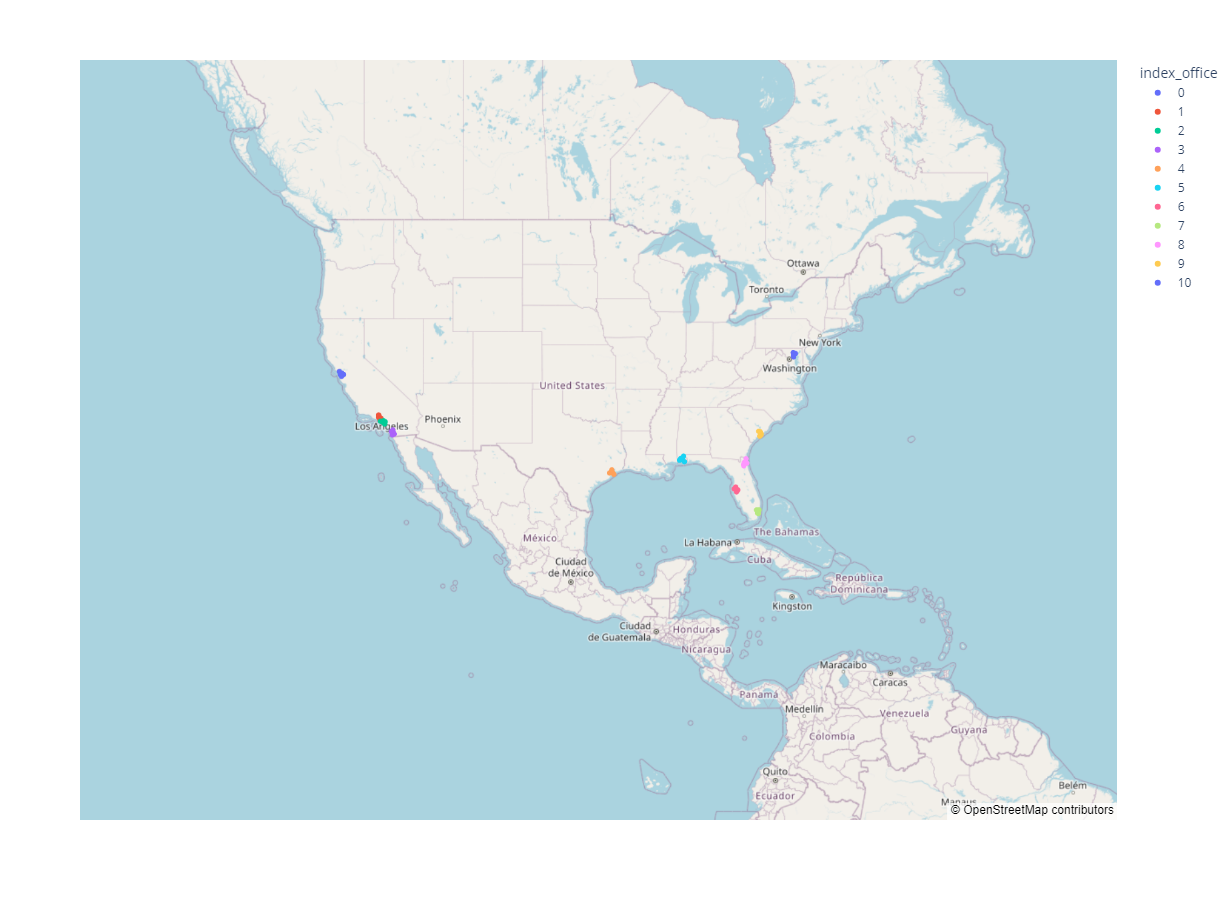

In [76]:
import pandas as pd
import plotly.express as px

df_plot = df_centers.iloc[np.ravel(ii).tolist()].copy()
df_plot['index_office'] = [str(i) for i in range(len(ii)) for _ in range(len(ii[0]))] 

fig = px.scatter_mapbox(df_plot, lat = 'latitude', lon = 'longitude', width = 800, height = 900,
                        color = 'index_office',
                        zoom = 2.8, mapbox_style = 'open-street-map')                      
fig.show()